In [1]:
#Throughout this document, things that can be changed by the user to investigate different 
#parts of the map are marked with #FINDME

# Import functions
import numpy as np
import matplotlib.pyplot as p
%matplotlib inline

import eigencurves
import eigenmaps
import kmeans
import bin_eigenspectra
import os
import pdb
import spiderman as sp

import gen_lightcurves
import healpy as hp

import colorcet as cc
from colormap2d import generate_map2d
from matplotlib import colorbar, cm
from matplotlib.colors import BoundaryNorm, Normalize
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
p.rc('text', usetex=True)
p.rc('font', family='serif')

import run_higher_sph_harm
from eigensource import plot_utils

from importlib import import_module
planet_name = 'HD189733b'
model_name = "quadrant_w_spikes" #FINDME: name of the model to perform the fit from

looking for spidermanrc file at /Users/megan/.spidermanrc


Set the Wavelength Grid

In [2]:
lammin = 2.41
lammax = 3.98

lamhr = np.linspace(lammin, lammax, 1000)

# Use `gen_lightcurves.spec_flat_with_gaussian()` to generate toy mock spectra

Text(0, 0.5, 'Fp/Fs')

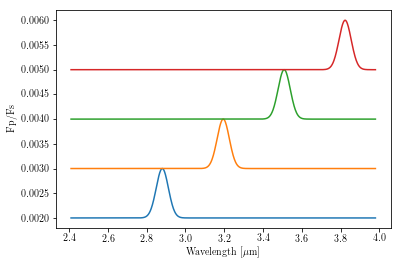

In [3]:
f1 = gen_lightcurves.spec_flat_with_gaussian(lamhr, A = 0.002, B = 0.001, std = 0.02, xroll = -0.20)
f2 = gen_lightcurves.spec_flat_with_gaussian(lamhr, A = 0.003, B = 0.001, std = 0.02, xroll = 0.0)  
f3 = gen_lightcurves.spec_flat_with_gaussian(lamhr, A = 0.004, B = 0.001, std = 0.02, xroll = 0.20) 
f4 = gen_lightcurves.spec_flat_with_gaussian(lamhr, A = 0.005, B = 0.001, std = 0.02, xroll = 0.40) 


p.plot(lamhr, f1)
p.plot(lamhr, f2)
p.plot(lamhr, f3)
p.plot(lamhr, f4)
p.xlabel("Wavelength [$\mu$m]")
p.ylabel("Fp/Fs")

# Use `gen_lightcurves.create_quadrant_map()` to paint the spectra onto the planet map

(3072, 1000)
(1000,)


/Users/megan/anaconda3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


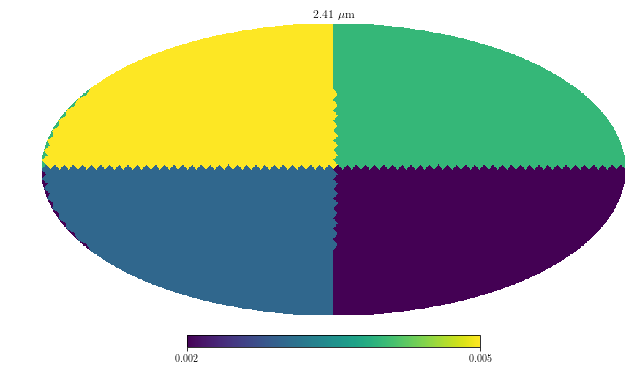

In [4]:
spaxels = gen_lightcurves.create_quadrant_map(f4, f3, f2, f1)
print(np.shape(spaxels))#3072
print(np.shape(f1))
plot_utils.show_orig_map(lamhr, spaxels);

# Generate new input lightcurves

/Users/megan/anaconda3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


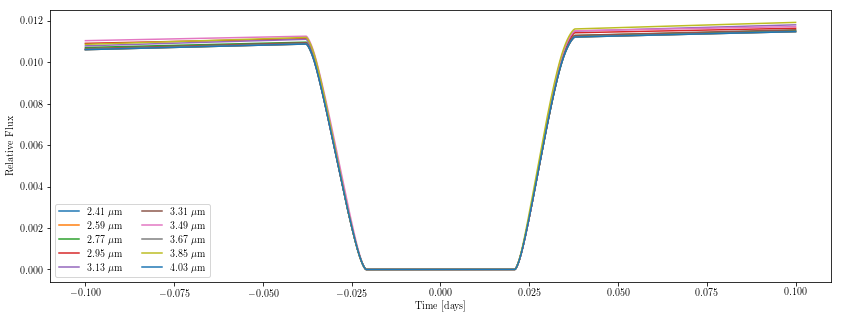

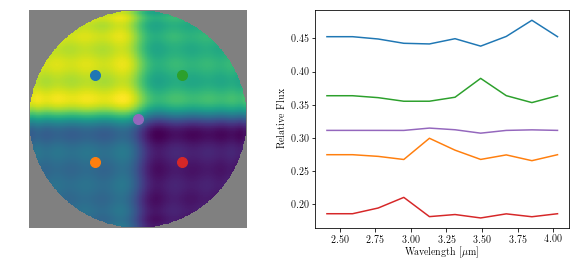

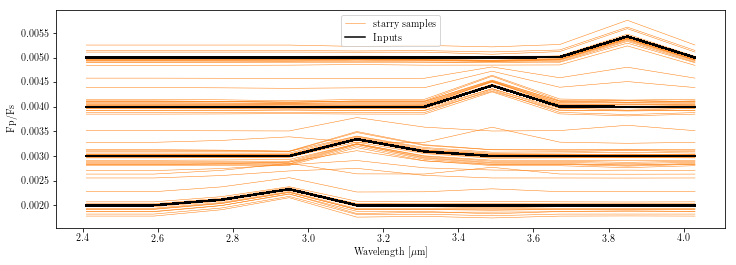

In [5]:
# Generate the multi-wavelength eclipse lightcurves using starry
time, lam, dlam, lcurves = gen_lightcurves.create_lightcurves_with_starry(lamhr, spaxels, 
                                                                          plot_lightcurves = True, 
                                                                          plot_diagnostic = True, 
                                                                          plot_points_on_map_spec=True)

# Save as a .npz file in data/input_lightcurves
filename='data/input_lightcurves/'+model_name+'.npz'
np.savez(filename,time=time,wl=lam,dwl=dlam,lightcurve=lcurves)

# Perform inference
This can take a while, but the results will be saved for faster future runs.

In [6]:
## Results are saved in data/sph_harmonic_coefficients_full_samples
for oneOrd in np.arange(2,3): #which degrees of spherical harmonics you want to create fits for
    run_higher_sph_harm.run_lc_noise_and_fit(norder=oneOrd,usePath=filename,afew=5)

Found the previously-run file data/sph_harmonic_coefficients_full_samples/quadrant_w_spikes/spherearray_deg_2.npz. Now exiting


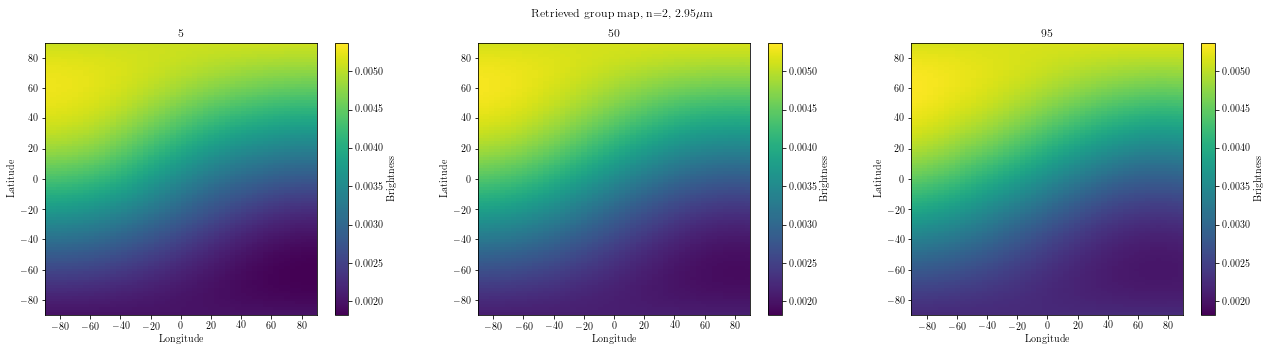

In [8]:
dataDir='data/sph_harmonic_coefficients_full_samples/'+model_name+'/'
waves, lats, lons = plot_utils.get_map_and_plot(waveInd=3,degree=2,dataDir=dataDir,isspider=True) #FINDME: using a different waveInd will show maps at a different wavelength; using a different degree will show a fit with a different number of spherical harmonics


In [12]:
print(np.shape(lons),np.shape(lats),np.shape(kgroups),np.shape(kgroup_draws))

(100, 60) (100, 60) (60, 100) (25, 60, 100)


In [9]:
degree=2 #FINDME: change this to investigate fits with different numbers of spherical harmonics
ngroups=4 #FINDME: change ngroups to cluster the data into a different number of eigengroups
extent=(np.max(time)-np.min(time))/2.21857567+180./360. #phase coverage of the eclipse observations
minlon=np.around(extent/2.*100)
lons=lons[:,int(100/2.-minlon):int(100/2.+minlon)]
lats=lats[:,int(100/2.-minlon):int(100/2.+minlon)]
eigenspectra_draws, kgroup_draws, maps = plot_utils.find_groups(dataDir,degree=degree,trySamples=25,
                                                                ngroups=ngroups,extent=extent,isspider=True)

Find the eigenspectra and their errors

(100, 60)
0.96 1.88
1.0 2.0


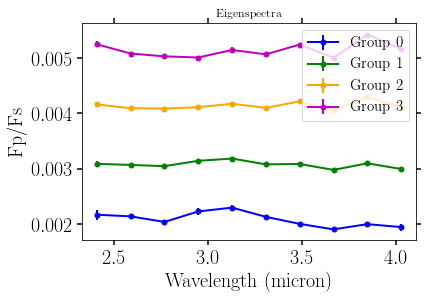

In [10]:
kgroups = plot_utils.show_spectra_of_groups(eigenspectra_draws,kgroup_draws,waves)

## Show histograms of group assignments

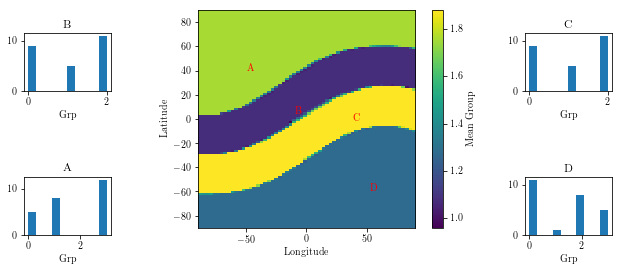

In [11]:
xLons= np.array([-50,-10,40,59]) * np.pi/180.
xLats= np.array([40,5, 0,-59]) * np.pi/180.
# xLons= np.array([-30]) * np.pi/180.
# xLats= np.array([45]) * np.pi/180.
saveName = 'plots/selected_group_histos_quad_model_5_eigencurves_deg_{}.pdf'.format(degree)
eigenmaps.show_group_histos(kgroups,lons,lats,kgroup_draws,
                            xLons=xLons,xLats=xLats,
                            saveName=saveName)

TypeError: Shape of x does not match that of z: found (100, 40) instead of (100, 60).

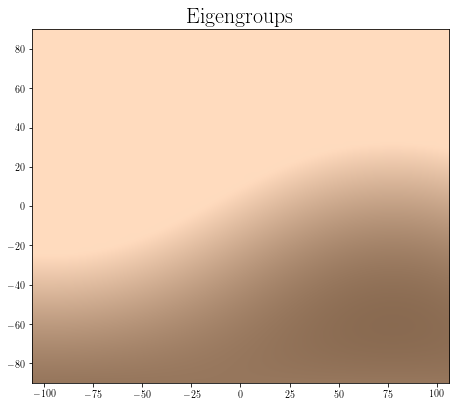

In [13]:
plot_utils.do_hue_maps(extent,maps,lons,lats,kgroups,ngroups,hueType='group')

TypeError: Shape of x does not match that of z: found (100, 40) instead of (100, 60).

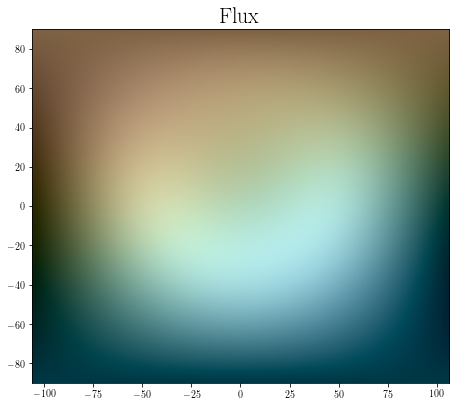

In [14]:
plot_utils.do_hue_maps(extent,maps,lons,lats,kgroups,ngroups,hueType='flux')